In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모듈 설치

In [ ]:
# 모델링 모듈
!pip install tensorflow-addons
!pip install neuralprophet[live]
!pip install prophet

In [ ]:
# 폰트설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 모듈 및 라이브러리

In [267]:
# 내장 라이브러리
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# 외장 라이브러리
from typing import collections, List, Tuple, Dict, DefaultDict, NewType
from collections import Counter
from datetime import datetime, timedelta
from timeit import default_timer as timer

# sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Facebook Prophet - 시계열 모델
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_yearly
# Neural Prophet - Advanced Facebook Prophet
from neuralprophet import NeuralProphet
# 시계열 모델
from statsmodels.tsa.arima_model import ARIMA
# Attention 모델
import keras
from tensorflow_addons.layers import MultiHeadAttention

In [268]:
# plot 한글
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

elif platform.system() == 'Linux': # colab 사용자의 경우에
  # 나눔고딕 폰트
  plt.rc('font', family='NanumBarunGothic') 


# 데이터 로드

In [269]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)연어


In [270]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [271]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [272]:
train, t_len = datasetting(data, name)
validation, v_len = datasetting(val_df, name)

In [273]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [274]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [275]:
x_train = data_frame(train, ctry_list)

In [276]:
x_val = data_frame(validation, ctry_list)

# 학습, 테스트 데이터 분리 

In [277]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [278]:
X_val = np.array(x_val.iloc[:,:-1])
Y_val = np.array(x_val.iloc[:,-1])
Y_val = Y_val.reshape(-1)

In [279]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((511, 14), (511,), (153, 14), (153,))

In [280]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [281]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [282]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [283]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [284]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [285]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [286]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [287]:
val_weight, val_price = make_weight(X_val, Y_val,v_len)

In [288]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [289]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [290]:
val_price = make_new_price(val_weight, val_price)

In [291]:
trn_lst = np.array([item for item in train_price if item > 0])

In [292]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])
validation['REG_DATE'] = pd.to_datetime(validation['REG_DATE'])

In [293]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

# RMSE 함수 (평가지표)

In [294]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

- validation y : val_price


# Neural Prophet - normal

In [295]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(197, 2)


In [296]:
val_date = list(validation['REG_DATE'].unique())

In [297]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

In [298]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(df, freq =freq,
                epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.94it/s, SmoothL1Loss=0.000236, MAE=0.0357, RegLoss=0]


In [299]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
future = m.make_future_dataframe(df, periods=52)
forecast = m.predict(future)

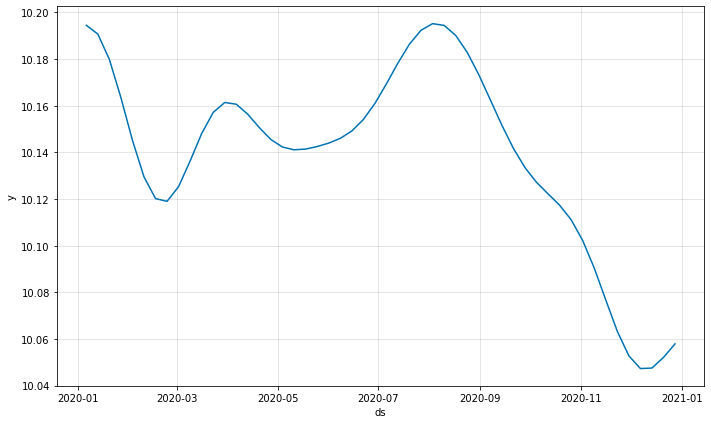

In [300]:
forecasts_plot = m.plot(forecast)

In [301]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [302]:
# rmse
rmse(val_price, a['yhat1'])

0.8242267569375189

# Neural Prophet - Trend

In [303]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.67it/s, SmoothL1Loss=8.49e-5, MAE=0.0179, RegLoss=0]


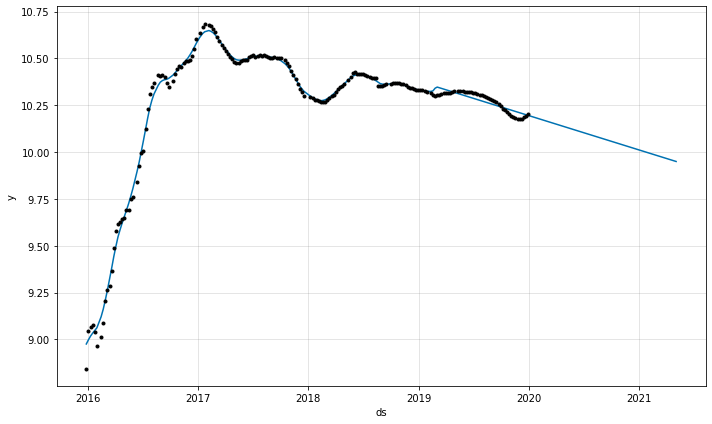

In [304]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)
forecasts_plot = m.plot(forecast)

In [305]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [306]:
# rmse
rmse(val_price, a['yhat1'])

0.8009833725576777

# Nueral Prophet - Seasonality

In [307]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 162
INFO:nprophet.config:Auto-set epochs to 162


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:09<00:00, 16.86it/s, SmoothL1Loss=0.00019, MAE=0.0263, RegLoss=4.53e-5]


In [308]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

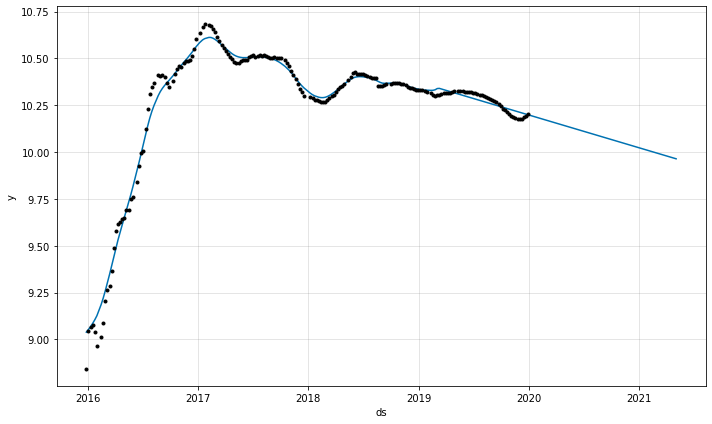

In [309]:
forecasts_plot = m.plot(forecast)

In [310]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [311]:
# rmse
rmse(val_price, a['yhat1'])

0.8026160004094812

# 최적 하이퍼 파라미터


In [312]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

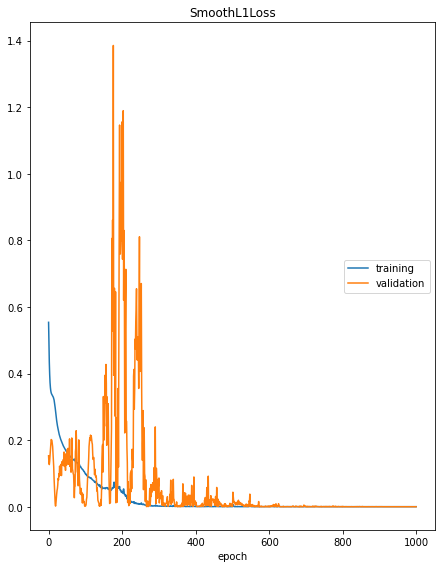

Epoch[1000/1000]: 100%|██████████| 1000/1000 [01:01<00:00, 16.16it/s, SmoothL1Loss=0.000189, MAE=0.0267, RegLoss=0.000856, MAE_val=0.0155, SmoothL1Loss_val=6.44e-5]


In [313]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [314]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast.tail()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
244,2020-11-30,NaN,9.756210,NaN,9.756209,-1.664207e-08,8.122704e-08
245,2020-12-07,NaN,9.748356,NaN,9.748356,-1.664207e-08,8.122704e-08
246,2020-12-14,NaN,9.740503,NaN,9.740502,-1.664207e-08,8.122704e-08
247,2020-12-21,NaN,9.732649,NaN,9.732649,-1.664207e-08,8.122704e-08
248,2020-12-28,NaN,9.724796,NaN,9.724795,-1.664207e-08,8.122704e-08


In [315]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [316]:
rmse(val_price, a['yhat1'])

0.7787814615854044

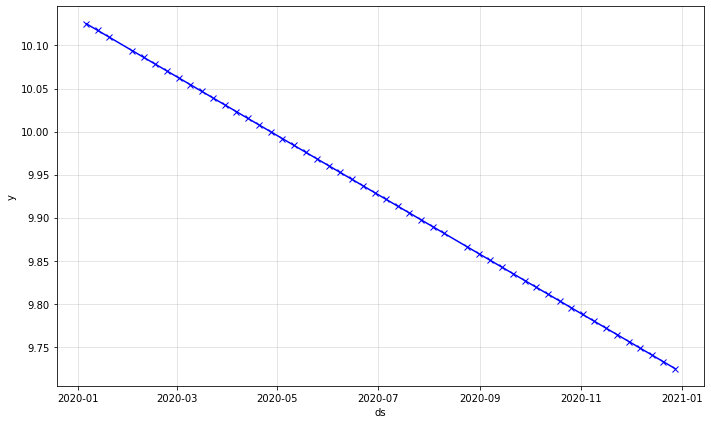

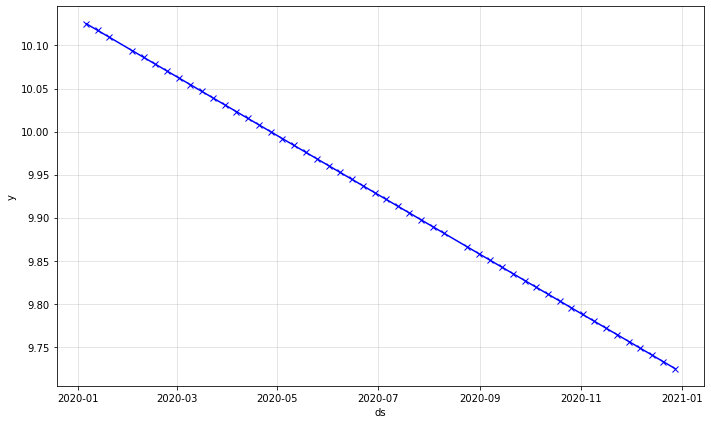

In [317]:
nprophet.plot(a)

# 최적 하이퍼 파라미터 ver.2

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

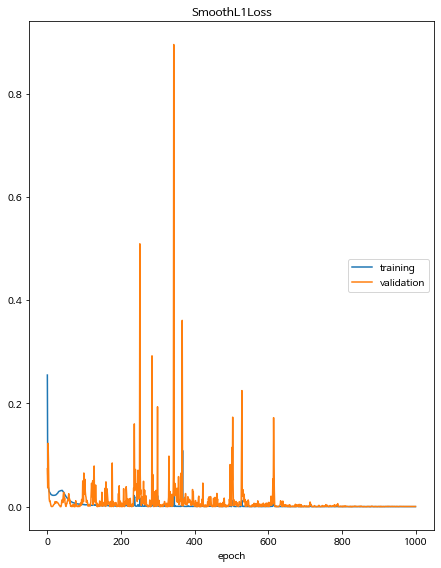

Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:46<00:00, 21.53it/s, SmoothL1Loss=0.000176, MAE=0.0225, RegLoss=0.00111, MAE_val=0.0517, SmoothL1Loss_val=0.00044]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)

,ds,y,yhat1,trend
244,2020-11-30,NaN,10.038338,10.038338
245,2020-12-07,NaN,10.036136,10.036136
246,2020-12-14,NaN,10.033934,10.033934
247,2020-12-21,NaN,10.031733,10.031732
248,2020-12-28,NaN,10.029530,10.029530


In [ ]:
# validation 날짜와 맞는 데이터 추출하기 위한 데이터 프레임
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])

for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)
rmse(val_price, a['yhat1'])

0.827206083943835

# 최적 하이퍼 파라미터 ver.3

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)
      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in val_date:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      result.loc[count] = lr, layer, changepoint, rmse(val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s, SmoothL1Loss=0.000299, MAE=0.0325, RegLoss=0.00121, MAE_val=0.0407, SmoothL1Loss_val=0.000287]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


42.73682764799992


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.25it/s, SmoothL1Loss=0.000329, MAE=0.0352, RegLoss=0.00137, MAE_val=0.0528, SmoothL1Loss_val=0.000436]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


89.99916476599992


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.28it/s, SmoothL1Loss=0.000183, MAE=0.0246, RegLoss=0.00116, MAE_val=0.0401, SmoothL1Loss_val=0.000279]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


133.15878236100002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.26it/s, SmoothL1Loss=0.000242, MAE=0.0283, RegLoss=0.00116, MAE_val=0.0258, SmoothL1Loss_val=0.000128]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.19222015499986


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.01it/s, SmoothL1Loss=0.00386, MAE=0.115, RegLoss=0.317, MAE_val=0.0426, SmoothL1Loss_val=0.000326]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


86.85742786499986


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s, SmoothL1Loss=0.00021, MAE=0.0266, RegLoss=0.00114, MAE_val=0.0288, SmoothL1Loss_val=0.000154]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


130.4900436979999


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.17it/s, SmoothL1Loss=0.000238, MAE=0.0281, RegLoss=0.00114, MAE_val=0.0471, SmoothL1Loss_val=0.000378]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.352488617999825


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.98it/s, SmoothL1Loss=0.000213, MAE=0.0266, RegLoss=0.00115, MAE_val=0.0517, SmoothL1Loss_val=0.000431]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


87.081424964


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s, SmoothL1Loss=0.0002, MAE=0.0261, RegLoss=0.00119, MAE_val=0.0325, SmoothL1Loss_val=0.000192]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


130.47755979


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.05it/s, SmoothL1Loss=0.000193, MAE=0.0236, RegLoss=0.00103, MAE_val=0.0283, SmoothL1Loss_val=0.000149]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.57884062099993


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.02it/s, SmoothL1Loss=0.000192, MAE=0.0238, RegLoss=0.00109, MAE_val=0.0279, SmoothL1Loss_val=0.000147]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


87.231497752


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s, SmoothL1Loss=0.000177, MAE=0.0229, RegLoss=0.00106, MAE_val=0.0406, SmoothL1Loss_val=0.000287]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


131.111195404


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:44<00:00, 22.62it/s, SmoothL1Loss=0.000208, MAE=0.0248, RegLoss=0.00106, MAE_val=0.0386, SmoothL1Loss_val=0.00025]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


44.408947319999925


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.92it/s, SmoothL1Loss=0.00375, MAE=0.11, RegLoss=0.317, MAE_val=0.052, SmoothL1Loss_val=0.000465]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


88.23461069700011


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s, SmoothL1Loss=0.00333, MAE=0.103, RegLoss=0.316, MAE_val=0.0525, SmoothL1Loss_val=0.00046]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


131.77529928599984


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s, SmoothL1Loss=0.00019, MAE=0.0235, RegLoss=0.00105, MAE_val=0.0404, SmoothL1Loss_val=0.000279]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.95945885500032


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.28it/s, SmoothL1Loss=0.00019, MAE=0.0237, RegLoss=0.00107, MAE_val=0.0429, SmoothL1Loss_val=0.000314]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


87.1097074180002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.10it/s, SmoothL1Loss=0.000179, MAE=0.0226, RegLoss=0.00109, MAE_val=0.0535, SmoothL1Loss_val=0.000469]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


130.57944685100028


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.05it/s, SmoothL1Loss=0.00415, MAE=0.116, RegLoss=0.316, MAE_val=0.0518, SmoothL1Loss_val=0.000445]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.572180165999725


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.06it/s, SmoothL1Loss=0.00018, MAE=0.0224, RegLoss=0.00105, MAE_val=0.0497, SmoothL1Loss_val=0.000404]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


87.13201452199974


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.95it/s, SmoothL1Loss=0.000176, MAE=0.022, RegLoss=0.00106, MAE_val=0.0293, SmoothL1Loss_val=0.000161]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


130.89718467500006


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s, SmoothL1Loss=0.00407, MAE=0.115, RegLoss=0.316, MAE_val=0.0489, SmoothL1Loss_val=0.000405]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.31005516699997


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s, SmoothL1Loss=0.000185, MAE=0.0225, RegLoss=0.00102, MAE_val=0.0498, SmoothL1Loss_val=0.000409]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


86.70790640800033


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.09it/s, SmoothL1Loss=0.000187, MAE=0.0228, RegLoss=0.00106, MAE_val=0.0507, SmoothL1Loss_val=0.000427]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


130.2292283669999


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 23.04it/s, SmoothL1Loss=0.000198, MAE=0.0238, RegLoss=0.00101, MAE_val=0.0373, SmoothL1Loss_val=0.000241]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


43.622257011999864


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:43<00:00, 22.76it/s, SmoothL1Loss=0.000194, MAE=0.0232, RegLoss=0.00103, MAE_val=0.05, SmoothL1Loss_val=0.000415]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


87.76394840800003


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:44<00:00, 22.32it/s, SmoothL1Loss=0.00338, MAE=0.104, RegLoss=0.316, MAE_val=0.0486, SmoothL1Loss_val=0.000402]


132.7754235880002


In [ ]:
result.sort_values(by='rmse', ascending=True)

,learning_rate,num_hidden_layers,n_changepoints,rmse
0,0.005,10.0,100.0,0.788047
1,0.005,10.0,150.0,0.792749
9,0.010,10.0,100.0,0.799216
10,0.010,10.0,150.0,0.799579
5,0.005,20.0,200.0,0.799591
3,0.005,20.0,100.0,0.801100
20,0.015,10.0,200.0,0.803057
8,0.005,30.0,200.0,0.806197
12,0.010,20.0,100.0,0.806443
24,0.015,30.0,100.0,0.809232


## 최적 하이퍼파라미터 적용(10회 실험)



In [318]:
## neural prophet
epochs = 1000
#batch_size = 64
learning_rate = 0.0005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 10 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 100 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=10

#n_lags = 5  # >error : lambda delay가 없다

In [319]:
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
count = 0
for king in range(10):
  nprophet = NeuralProphet(
                            yearly_seasonality=False, 
                            weekly_seasonality=False, 
                            daily_seasonality=False,
                            learning_rate=learning_rate, 
                            changepoints_range=changepoints_range, 
                            n_forecasts=n_forecasts,
                            ar_sparsity=ar_sparsity, 
                            n_changepoints=n_changepoints, 
                            growth='logistic', 
                            seasonality_mode='multiplicative', 
                            trend_reg=trend_reg,
                            num_hidden_layers=num_hidden_layers,
                            seasonality_reg = seasonality_reg)

  nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
  #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
  future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
  forecast = nprophet.predict(future)
  a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
  for i in val_date:
    a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
  a.reset_index(drop=True, inplace = True)
  result.loc[count] = learning_rate, num_hidden_layers, n_changepoints, rmse(val_price, a['yhat1'])
  count += 1

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO:nprophet.config:Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s, SmoothL1Loss=0.000793, MAE=0.0627, RegLoss=0.000743, MAE_val=0.0676, SmoothL1Loss_val=0.000645]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
ERROR:nprophet.config:Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__

In [320]:
result.sort_values(by='rmse')

,learning_rate,num_hidden_layers,n_changepoints,rmse
8,0.0005,10.0,100.0,0.782478
5,0.0005,10.0,100.0,0.789659
0,0.0005,10.0,100.0,0.810391
3,0.0005,10.0,100.0,0.827097
4,0.0005,10.0,100.0,0.872640
9,0.0005,10.0,100.0,1.037965
1,0.0005,10.0,100.0,1.070898
6,0.0005,10.0,100.0,1.284483
2,0.0005,10.0,100.0,1.424351
7,0.0005,10.0,100.0,1.754915


In [321]:
np.mean(result['rmse'].values)

1.065487805882788

## Facebook Prophet 실험

In [ ]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 

In [ ]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(197, 2)


In [ ]:
# Facebook Prophet 모델 개체 생성 
m = Prophet(changepoint_prior_scale=0.03)
#m.add_seasonality(name='weekly',period=7, fourier_order=20)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
#m.add_seasonality(name='quarterly', period=365.25/4,fourier_order=5, prior_scale=15)

In [ ]:
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=52, freq=freq)
forecast = m.predict(future)  

In [ ]:
pred_date = forecast.loc[forecast['ds'] > '2020-01-01', ('ds')].unique()

In [ ]:
a = pd.DataFrame(columns=['ds','yhat'])
for i in pred_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i,('ds','yhat')].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
rmse(val_price, a['yhat'])

0.9591933756854065

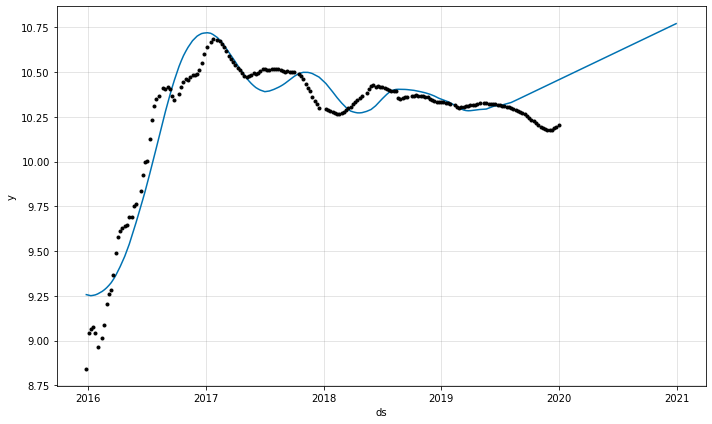

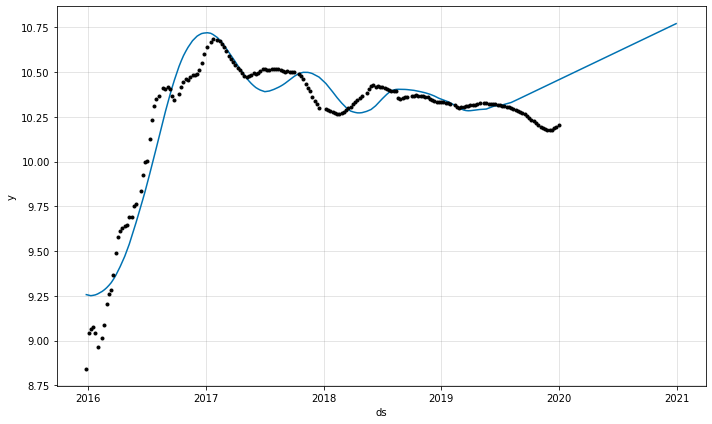

In [322]:
nprophet.plot(forecast)